# DID pre-trend and reduced-form regressions

## Baseline Analysis

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import AbsorbingLS
from linearmodels import PanelOLS
import itertools
import warnings
from linearmodels.iv.absorbing import AbsorbingEffectWarning
import psutil
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
# Get the virtual memory details
memory_info = psutil.virtual_memory()
total_memory = memory_info.total
available_memory = memory_info.available
used_memory = memory_info.used

print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")
print(f"Used Memory: {used_memory / (1024 ** 3):.2f} GB")

Total Memory: 7.45 GB
Available Memory: 1.09 GB
Used Memory: 6.36 GB


In [5]:
# Step 8: Define the function to run regressions
def run_regression(df, outcome_var, edum_vars, control_vars):
    # Ensure the dataframe is indexed properly with MultiIndex for fixed effects
    df_regression = df.copy()
    #df_regression.set_index(['indivID', 'group_timeID'], inplace=True)
    
    # Combining edum* and control variables
    df2 = df_regression[[outcome_var] + edum_vars + control_vars + ['clustID']].dropna()
    X = df2[edum_vars + control_vars]
    y = df2[outcome_var]
    
    # Running the PanelOLS regression with fixed effects and clustering by clustID
    #model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True, check_rank=False).fit(cov_type='clustered', clusters=df_regression['clustID'])

    # Absorbing fixed effects (indivID and group_timeID) and clustering by clustID
    model = AbsorbingLS(y, X,  drop_absorbed=True).fit(cov_type='clustered', clusters=df2['clustID'])

    
    return model

In [6]:
# Define function to plot event study results
def plot_event_study(betas, std_errors, title, x_labels):
    # Compute the confidence intervals (95% CI)
    lower_bound = betas - 1.96 * std_errors
    upper_bound = betas + 1.96 * std_errors

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Plot the point estimates (betas)
    plt.errorbar(x_labels, betas, yerr=1.96*std_errors, fmt='o', capsize=5, capthick=2, color='blue')

    # Add horizontal and vertical lines for reference
    plt.axhline(0, color='grey', linestyle='--')  # y=0 horizontal line
    plt.axvline(0, color='grey', linestyle='--')  # x=0 vertical line (time of merger)

    # Add labels and title
    plt.xlabel("Years since merger")
    plt.title(title)

    # Show the plot
    plt.show()

In [7]:
df = pd.read_csv("./Final Data/analysis_input.csv")
df['principal_city_binary'] = df['principal_city'] = np.where(df['principal_city'] == 999999, np.nan, np.where(df['principal_city'] == 0, 0, 1))
df['urban_rural_binary'] = np.where(df['urbanrural'].isin(['M', 'U']), 1, np.where(df['urbanrural'] == 'R', 0, np.nan))
# Merger Sample
df = df.dropna(subset=['overlap'])
df_final = df.copy()

control_vars = ['poptot', 'popden', 'pminority', 'pcollege', 'medincome', 'total_branches_county', 'avg_branch_growth_county']
edum_vars = [col for col in df.columns if 'edum_' in col]

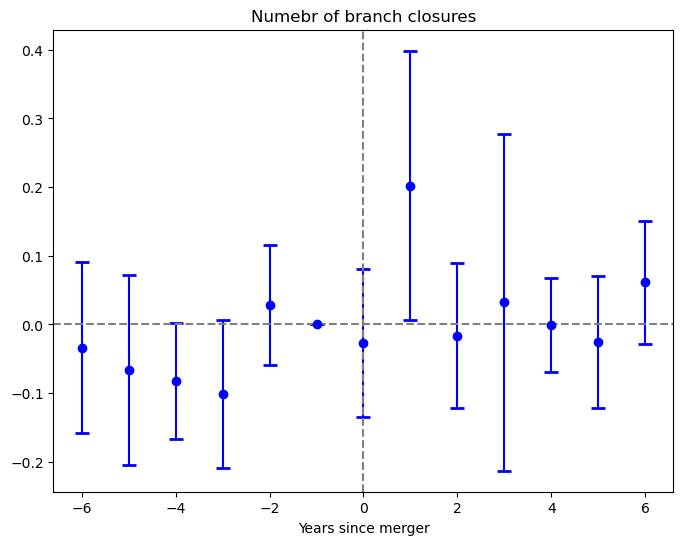

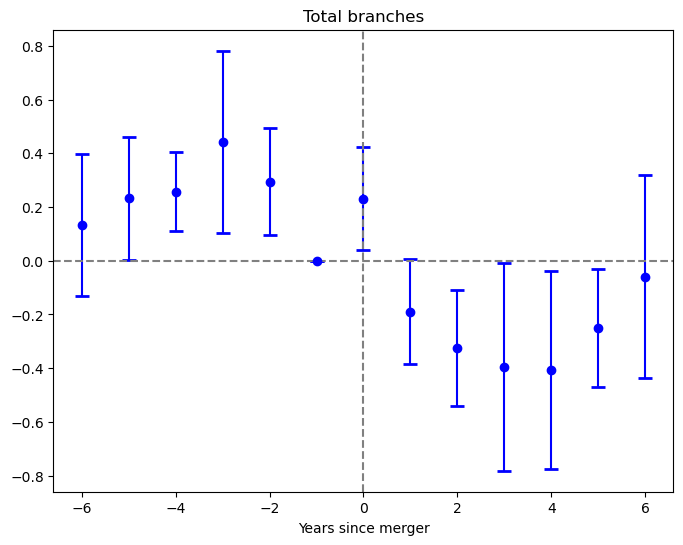

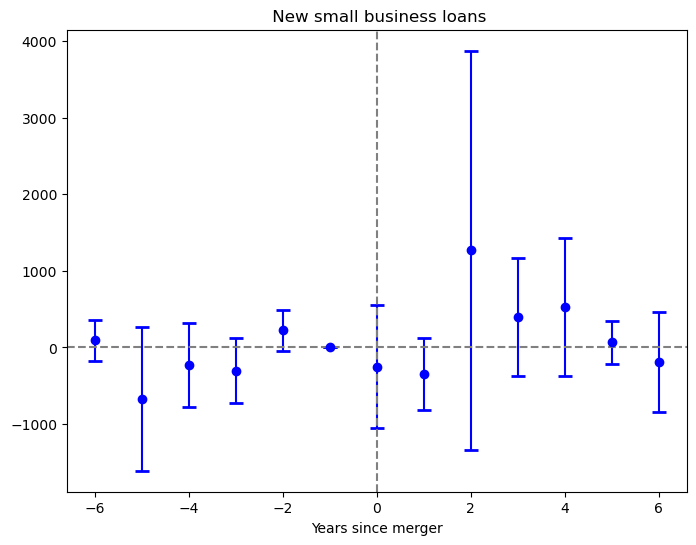

                          Clo_Beta  Clo_pvalues  Tot_Beta  Tot_pvalues  \
edum_lessm5                 -0.034        0.597     0.133        0.323   
edum_n5                     -0.067        0.345     0.233        0.046   
edum_n4                     -0.082        0.057     0.258        0.001   
edum_n3                     -0.101        0.066     0.443        0.011   
edum_n2                      0.028        0.531     0.294        0.004   
edum_0                      -0.026        0.632     0.230        0.018   
edum_1                       0.202        0.043    -0.189        0.059   
edum_2                      -0.016        0.765    -0.325        0.003   
edum_3                       0.032        0.797    -0.396        0.044   
edum_4                      -0.001        0.976    -0.407        0.031   
edum_5                      -0.026        0.593    -0.249        0.026   
edum_great5                  0.062        0.177    -0.059        0.760   
poptot                       0.000    

In [9]:
model1 = run_regression(df_final, 'branch_closures_tract', edum_vars, control_vars)
model2 = run_regression(df_final, 'total_branches_tract', edum_vars, control_vars)
model3 = run_regression(df_final, 'vol_sbus', edum_vars, control_vars) # sbl_total vol_100k vol_250k vol_1mil vol_sbus
#print(round(pd.DataFrame({'Clo_Beta':model1.params[0:14], 'Clo_SD':model1.std_errors[0:14], 'Tot_Beta':model2.params[0:14], 'Tot_SD':model2.std_errors[0:14],
#                'SBL_Beta':model3.params[0:14], 'SBL_SD':model3.std_errors[0:14]}),    3))
years_since_merger = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]
plot_event_study(pd.concat([model1.params[0:5], pd.Series([0]), model1.params[5:12]], ignore_index=True), pd.concat([model1.std_errors[0:5], pd.Series([0]), model1.std_errors[5:12]], ignore_index=True), "Numebr of branch closures", years_since_merger)
plot_event_study(pd.concat([model2.params[0:5], pd.Series([0]), model2.params[5:12]], ignore_index=True), pd.concat([model2.std_errors[0:5], pd.Series([0]), model2.std_errors[5:12]], ignore_index=True), "Total branches", years_since_merger)
plot_event_study(pd.concat([model3.params[0:5], pd.Series([0]), model3.params[5:12]], ignore_index=True), pd.concat([model3.std_errors[0:5], pd.Series([0]), model3.std_errors[5:12]], ignore_index=True), " New small business loans", years_since_merger)
print(round(pd.DataFrame({'Clo_Beta':model1.params, 'Clo_pvalues':model1.pvalues, 'Tot_Beta':model2.params, 'Tot_pvalues':model2.pvalues,
                'SBL_Beta':model3.params, 'SBL_pvalues':model3.pvalues}),    3))

#print(round(pd.DataFrame({'Clo_Beta':model1.params[0:14], 'Clo_SD':model1.std_errors[0:14], 'Tot_Beta':model2.params[0:14], 'Tot_SD':model2.std_errors[0:14],
#                'SBL_Beta':model3.params[0:14], 'SBL_SD':model3.std_errors[0:14]}),    3))

In [10]:
# Step 10: Handle the second part (calculating mean for specific observations)
df_means = df[(df['event_year'] == -1) & (df['overlap'] == 1)].copy()

# Calculate means for num_closings and totalbranches
mean_num_closings = df_means['branch_closures'].mean()
mean_totalbranches = df_means['total_branches_tract'].mean()
mean_NumSBL_Rev1 = df_means['sbl_total'].mean()
mean_total_origin = df_means['vol_sbus'].mean()


# Print scalar results (equivalent to scalar list in Stata)
print(f'Mean branch_closures_tract: {mean_num_closings}')
print(f'Mean total_branches_tract: {mean_totalbranches}')
print(f'Mean sbl_total: {mean_NumSBL_Rev1}')
print(f'Mean vol_sbus: {mean_total_origin}')

Mean branch_closures_tract: 0.03773584905660377
Mean total_branches_tract: 5.431677018633541
Mean sbl_total: 14142.099378881987
Mean vol_sbus: 3272.88198757764
